## Setup

(1) Install IPyKernel

```console
pip install ipykernel
```

(2) Install FlexMeasures IPython Kernel

```console
ipython -m ipykernel install --user --name=fm
```

In [1]:
from flexmeasures.app import create
from flexmeasures.data.models.time_series import Sensor

from datetime import timedelta

from flexmeasures.data.utils import save_to_db

from sqlalchemy import select, update
import time

import timely_beliefs as tb
import pandas as pd
import numpy as np

from flexmeasures.data.services.utils import get_or_create_model
from flexmeasures import Asset, Sensor, AssetType, Account, Source
from flexmeasures.data.models.time_series import TimedBelief

app = create()

[FLEXMEASURES][2024-06-19 13:33:58,025] WARNING: 'FLASK_ENV' is deprecated and replaced by FLEXMEASURES_ENV Change FLASK_ENV to FLEXMEASURES_ENV in the environment variables
[FLEXMEASURES][2024-06-19 13:33:58,027] INFO: Loading config from /home/felix/PycharmProjects/flexmeasures/instance/flexmeasures.cfg ...
[FLEXMEASURES][2024-06-19 13:33:58,031] INFO: [FLEXMEASURES] No SENTRY_DSN setting found, so initialising Sentry cannot happen ...


'FLASK_ENV' is deprecated and will not be used in Flask 2.3. Use 'FLASK_DEBUG' instead.


[FLEXMEASURES][2024-06-19 13:33:59,348] WARNING: `app.reporters` is deprecated. Use `app.data_generators["reporter"]` instead.
[FLEXMEASURES][2024-06-19 13:33:59,636] INFO: Loaded plugins: {}


In [2]:
ctx = app.app_context()

In [3]:
ctx.__enter__()

In [4]:
from flexmeasures.data.models.planning.linear_optimization import device_scheduler
import pandas as pd

COLUMNS = [
    "equals",
    "max",
    "min",
    "efficiency",
    "derivative equals",
    "derivative max",
    "derivative min",
    "derivative down efficiency",
    "derivative up efficiency",
    "stock delta",
]

In [218]:
import numpy as np
resolution = timedelta(minutes=15)
dt = pd.date_range("2024-01-01", "2024-01-02", freq="15min", inclusive="left")

commitment_upwards_deviation_price = pd.Series([100]*len(dt), index=dt) # Consumption Price
commitment_downwards_deviation_price = pd.Series([70]*len(dt), index=dt) # Production

#commitment_downwards_deviation_price[:10] = 10
#commitment_upwards_deviation_price[:10] = 10

commitment_upwards_deviation_price += -np.arange(len(dt))*0.2
commitment_downwards_deviation_price += -np.arange(len(dt))*0.2

commitment_quantities = pd.Series([0]*len(dt), index=dt)

ems_constraints = pd.DataFrame(columns=COLUMNS, index=dt)
ems_constraints["derivative max"] = 30
ems_constraints["derivative min"] = -30

n_devices = 1

soc_at_start = 10

soc_min = 20
soc_max = 80

storage_efficiency = 1
roundtrip_efficiency = .9

# Base device constraints
dc_main =  pd.DataFrame(columns=COLUMNS, index=dt)
dc_main["min"] = (soc_min - soc_at_start) * timedelta(hours=1) / resolution
dc_main["max"] =  (soc_max - soc_at_start) * timedelta(hours=1) / resolution

dc_main["efficiency"] = storage_efficiency

dc_main["derivative max"] = 5.7
dc_main["derivative min"] = -5.7

dc_main["derivative down efficiency"] = roundtrip_efficiency ** .5
dc_main["derivative up efficiency"] = roundtrip_efficiency ** .5

#dc_main["max"][-20] = (110 - soc_at_start) * timedelta(hours=1) / resolution
dc_main["min"][-20] = (70 - soc_at_start) * timedelta(hours=1) / resolution
# dc_main["equals"][-20] = (110 - soc_at_start) * timedelta(hours=1) / resolution

device_constraints = []

#device_constraints.append(dc_main)

for i in range(n_devices):
    dc = dc_main.copy()
    #dc["derivative down efficiency"] += 1
    device_constraints.append(dc)

# # Add some inflexible
# dc =  pd.DataFrame(columns=COLUMNS, index=dt)
# dc["derivative equals"] = 1
# dc["derivative equals"][10:20] = -2
# dc["derivative equals"][20:40] = -1.5
# dc["derivative equals"][40:50] = -2
# dc["derivative equals"][70:80] = -2
# dc *= -1
# device_constraints.append(dc)


/tmp/ipykernel_32052/2752493357.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_main["min"][-20] = (70 - soc_at_start) * timedelta(hours=1) / resolution


In [219]:
planned_power_per_device, planned_costs, results, model = device_scheduler(
    device_constraints,
    ems_constraints,
    [commitment_quantities],
    [commitment_downwards_deviation_price],
    [commitment_upwards_deviation_price],
    initial_stock = soc_at_start * (timedelta(hours=1) / resolution),
    ems_flow_relaxed = False,
    device_stock_relaxed = True,
    ems_flow_relaxation_cost = 20000,
    stock_relaxation_cost = 20000,
)

[FLEXMEASURES][2024-06-19 14:41:26,059] INFO: Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
[FLEXMEASURES][2024-06-19 14:41:26,072] INFO: Copyright (c) 2023 HiGHS under MIT licence terms


In [220]:
from flexmeasures.utils.calculations import integrate_time_series
soc_schedule = integrate_time_series(
        planned_power_per_device[0],
        soc_at_start,
        up_efficiency=roundtrip_efficiency**0.5,
        down_efficiency=roundtrip_efficiency**0.5,
        storage_efficiency=storage_efficiency,
        decimal_precision=6,
    )

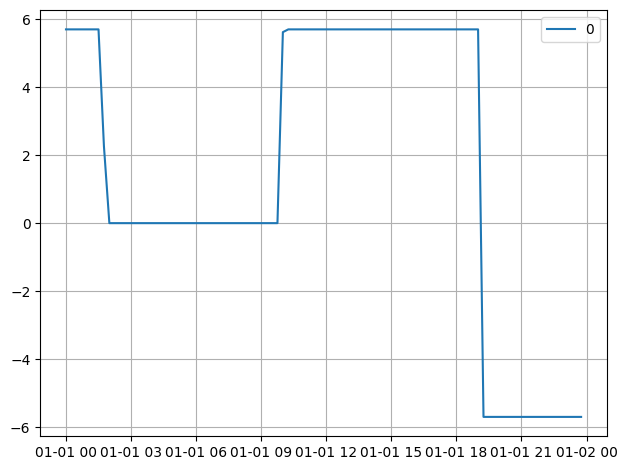

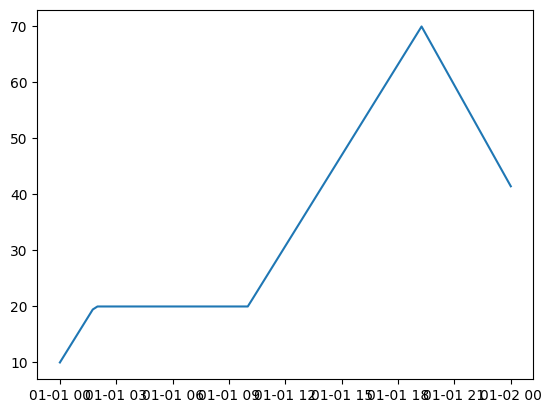

In [221]:
import matplotlib.pyplot as plt
for i, power in enumerate(planned_power_per_device):
    plt.plot(power, label=i)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.plot(soc_schedule)

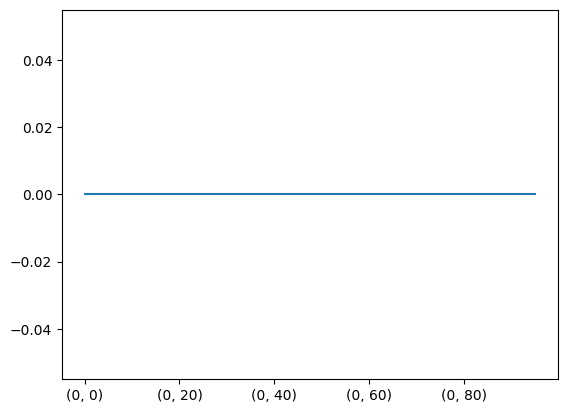

<TerminationCondition.optimal: 'optimal'>

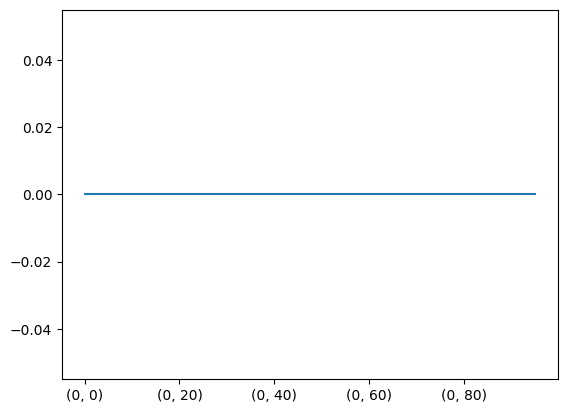

In [216]:
results.solver.termination_condition
pd.Series(model.device_stock_slack_lower.extract_values()).plot()
plt.show()
pd.Series(model.device_stock_slack_upper.extract_values()).plot()
results.solver.termination_condition

In [217]:
planned_costs

17748.38877695037

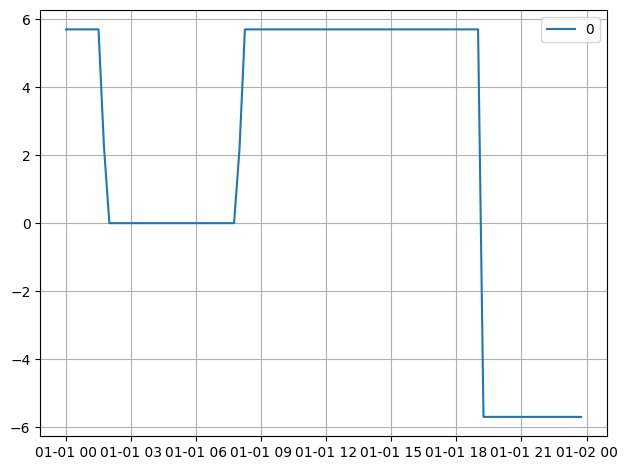

In [170]:
import matplotlib.pyplot as plt
for i, power in enumerate(planned_power_per_device):
    plt.plot(power, label=i)
plt.legend()
plt.grid()
plt.tight_layout()

In [ ]:
min(sum(planned_power_per_device)), max(sum(planned_power_per_device))

In [ ]:
plt.plot(sum(planned_power_per_device))

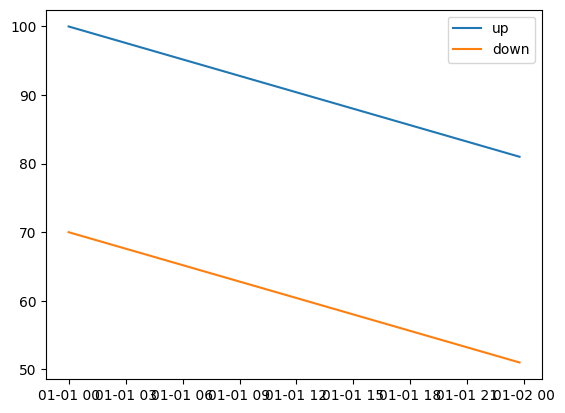

In [9]:
plt.plot(commitment_upwards_deviation_price, label="up")
plt.plot(commitment_downwards_deviation_price, label="down")

plt.legend()